In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.0
True


In [ ]:
if torch.cuda.is_available():
    print("CUDA Device Name:", torch.cuda.get_device_name(0))

CUDA Device Name: NVIDIA RTX A2000


In [ ]:
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
device = torch.device("cuda")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_dir = r'C:\Users\aaa\Documents\DATASETS\Organized_Amharic_Character_Dataset'
dataset = ImageFolder(root=data_dir, transform=transform)
targets = np.array(dataset.targets)

train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, stratify=targets, random_state=42)
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

print("Data loaders are ready")

for images, labels in train_loader:
    print(images.shape)
    break

Data loaders are ready
torch.Size([64, 1, 224, 224])


In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from typing import Dict, List

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: str = 'cuda'):

    results = {
        "train_loss": [],
        "train_acc": [],
        "train_precision": [],
        "train_recall": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": []
    }

    total_training_time = 0

    for epoch in range(epochs):
        start_time = time.time()

        train_loss, train_acc, train_precision, train_recall, train_f1 = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        val_loss, val_acc, val_precision, val_recall, val_f1 = validate_step(
            model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        epoch_time = time.time() - start_time
        total_training_time += epoch_time

        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"train_precision: {train_precision:.4f} | "
            f"train_recall: {train_recall:.4f} | "
            f"train_f1: {train_f1:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f} | "
            f"val_precision: {val_precision:.4f} | "
            f"val_recall: {val_recall:.4f} | "
            f"val_f1: {val_f1:.4f} | "
            f"epoch_time: {epoch_time:.2f} seconds"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        results["val_precision"].append(val_precision)
        results["val_recall"].append(val_recall)
        results["val_f1"].append(val_f1)

    print(f"Total training time: {total_training_time:.2f} seconds")

    return results

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str = 'cuda'):
    model.train()

    train_loss, train_acc = 0, 0
    all_preds = []
    all_labels = []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        all_preds.extend(y_pred_class.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        if (batch + 1) % 10 == 0:
            avg_loss = train_loss / (batch + 1)
            avg_acc = train_acc / (batch + 1)
            print(f"Processed {batch + 1}/{len(dataloader)} batches. Current loss: {avg_loss:.4f}")

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    train_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return train_loss, train_acc, train_precision, train_recall, train_f1

def validate_step(model: torch.nn.Module,
                  dataloader: torch.utils.data.DataLoader,
                  loss_fn: torch.nn.Module,
                  device: str = 'cuda'):
    model.eval()

    val_loss, val_acc = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = val_pred_logits.argmax(dim=1)
            all_preds.extend(val_pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            val_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))

    val_loss /= len(dataloader)
    val_acc /= len(dataloader)

    val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return val_loss, val_acc, val_precision, val_recall, val_f1

def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']
    val_loss = results['val_loss']

    accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.show()

In [ ]:
#vgg16
import torch
import torch.nn as nn
import torchvision.models as models

vgg16 = models.vgg16(weights='DEFAULT')

vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])

class CustomVGG16(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomVGG16, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 238

device = torch.device("cuda")
model_1 = CustomVGG16(vgg16, num_classes).to(device)
print("Model 1 setup complete")

for param in model_1.parameters():
    param.requires_grad = True

print("Parameter status after unfreezing all layers and applying dropout:")
for name, param in model_1.named_parameters():
    print(f"{name}: Requires grad: {param.requires_grad}")

Model 1 setup complete
Parameter status after unfreezing all layers and applying dropout:
base_model.features.0.weight: Requires grad: True
base_model.features.2.weight: Requires grad: True
base_model.features.2.bias: Requires grad: True
base_model.features.5.weight: Requires grad: True
base_model.features.5.bias: Requires grad: True
base_model.features.7.weight: Requires grad: True
base_model.features.7.bias: Requires grad: True
base_model.features.10.weight: Requires grad: True
base_model.features.10.bias: Requires grad: True
base_model.features.12.weight: Requires grad: True
base_model.features.12.bias: Requires grad: True
base_model.features.14.weight: Requires grad: True
base_model.features.14.bias: Requires grad: True
base_model.features.17.weight: Requires grad: True
base_model.features.17.bias: Requires grad: True
base_model.features.19.weight: Requires grad: True
base_model.features.19.bias: Requires grad: True
base_model.features.21.weight: Requires grad: True
base_model.feat

In [ ]:
try:
    import torchinfo
except ImportError:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

input_size = [1, 1, 224, 224]

summary(model_1, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
CustomVGG16                              [1, 238]                  --
├─VGG: 1-1                               [1, 4096]                 --
│    └─Sequential: 2-1                   [1, 512, 7, 7]            --
│    │    └─Conv2d: 3-1                  [1, 64, 224, 224]         576
│    │    └─ReLU: 3-2                    [1, 64, 224, 224]         --
│    │    └─Conv2d: 3-3                  [1, 64, 224, 224]         36,928
│    │    └─ReLU: 3-4                    [1, 64, 224, 224]         --
│    │    └─MaxPool2d: 3-5               [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-6                  [1, 128, 112, 112]        73,856
│    │    └─ReLU: 3-7                    [1, 128, 112, 112]        --
│    │    └─Conv2d: 3-8                  [1, 128, 112, 112]        147,584
│    │    └─ReLU: 3-9                    [1, 128, 112, 112]        --
│    │    └─MaxPool2d: 3-10              [1, 128, 56, 56]          --
│

In [ ]:
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.0001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.3)

Processed 10/472 batches. Current loss: 5.4961
Processed 20/472 batches. Current loss: 5.4880
Processed 30/472 batches. Current loss: 5.4856
Processed 40/472 batches. Current loss: 5.4818
Processed 50/472 batches. Current loss: 5.4789
Processed 60/472 batches. Current loss: 5.4770
Processed 70/472 batches. Current loss: 5.4749
Processed 80/472 batches. Current loss: 5.4712
Processed 90/472 batches. Current loss: 5.4649
Processed 100/472 batches. Current loss: 5.4547
Processed 110/472 batches. Current loss: 5.4423
Processed 120/472 batches. Current loss: 5.4147
Processed 130/472 batches. Current loss: 5.3752
Processed 140/472 batches. Current loss: 5.3368
Processed 150/472 batches. Current loss: 5.2924
Processed 160/472 batches. Current loss: 5.2445
Processed 170/472 batches. Current loss: 5.1933
Processed 180/472 batches. Current loss: 5.1420
Processed 190/472 batches. Current loss: 5.0847
Processed 200/472 batches. Current loss: 5.0290
Processed 210/472 batches. Current loss: 4.9647
P

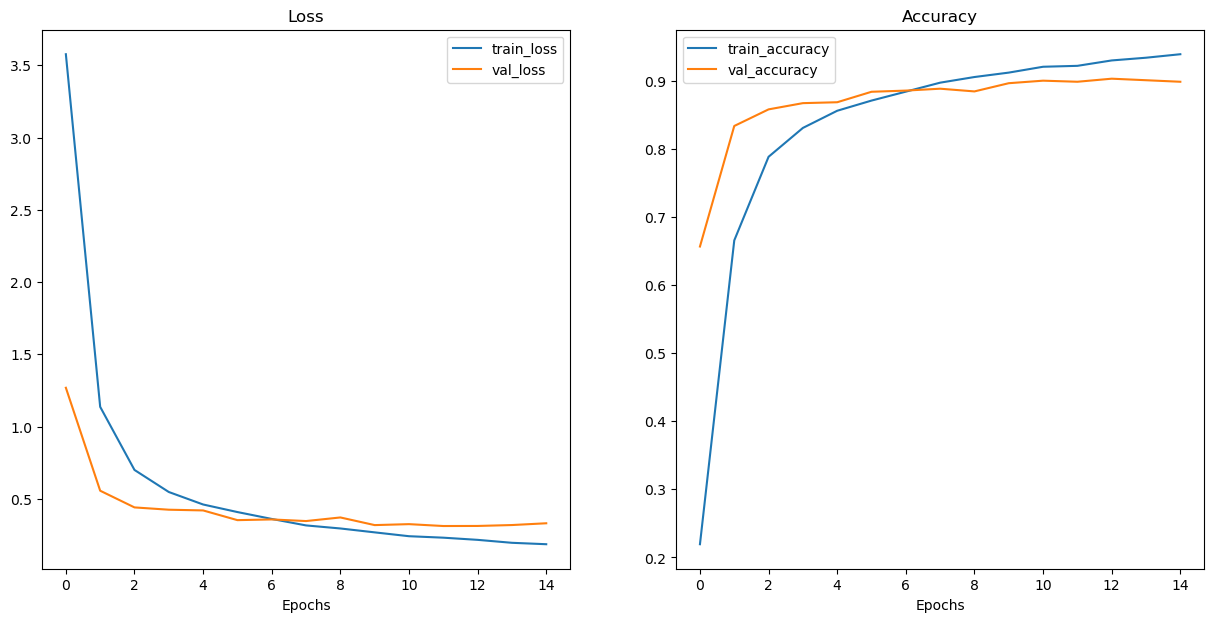

In [ ]:
epochs = 15
results = train(model_1, train_loader, val_loader, optimizer, criterion, epochs)
plot_loss_curves(results)
torch.save(model_1.state_dict(), 'model_1_weights.pth')

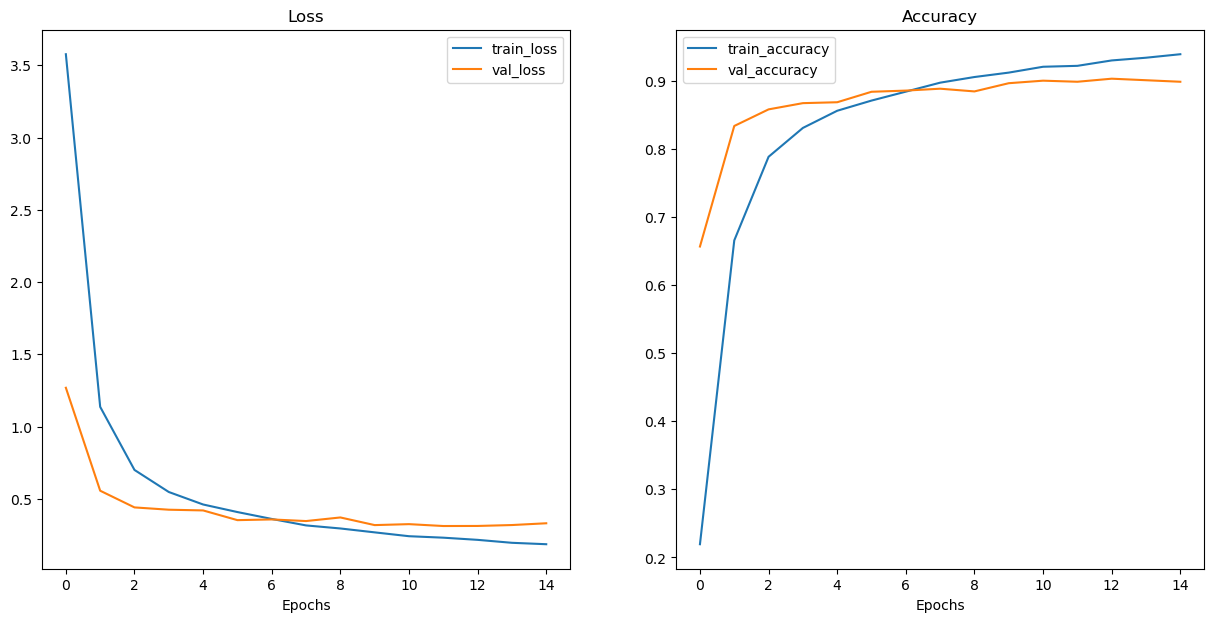

In [ ]:
plot_loss_curves(results)

In [ ]:
torch.save(model_1.state_dict(), 'model_1_weights.pth')

In [ ]:
#resnet50
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)

resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

resnet50 = nn.Sequential(*list(resnet50.children())[:-1])

class CustomResNet50(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomResNet50, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 238

device = torch.device("cuda")
model_3 = CustomResNet50(resnet50, num_classes).to(device)
print("Model 3 setup complete")

for param in model_3.parameters():
    param.requires_grad = True

print("Parameter status after unfreezing all layers and applying dropout:")
for name, param in model_3.named_parameters():
    print(f"{name}: Requires grad: {param.requires_grad}")

Model 3 setup complete
Parameter status after unfreezing all layers and applying dropout:
base_model.0.weight: Requires grad: True
base_model.1.weight: Requires grad: True
base_model.1.bias: Requires grad: True
base_model.4.0.conv1.weight: Requires grad: True
base_model.4.0.bn1.weight: Requires grad: True
base_model.4.0.bn1.bias: Requires grad: True
base_model.4.0.conv2.weight: Requires grad: True
base_model.4.0.bn2.weight: Requires grad: True
base_model.4.0.bn2.bias: Requires grad: True
base_model.4.0.conv3.weight: Requires grad: True
base_model.4.0.bn3.weight: Requires grad: True
base_model.4.0.bn3.bias: Requires grad: True
base_model.4.0.downsample.0.weight: Requires grad: True
base_model.4.0.downsample.1.weight: Requires grad: True
base_model.4.0.downsample.1.bias: Requires grad: True
base_model.4.1.conv1.weight: Requires grad: True
base_model.4.1.bn1.weight: Requires grad: True
base_model.4.1.bn1.bias: Requires grad: True
base_model.4.1.conv2.weight: Requires grad: True
base_model

In [ ]:
try:
    import torchinfo
except ImportError:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

input_size = [1, 1, 299, 299]

summary(model_3, input_size=input_size)

Layer (type:depth-idx)                        Output Shape              Param #
CustomResNet50                                [1, 238]                  --
├─Sequential: 1-1                             [1, 2048, 1, 1]           --
│    └─Conv2d: 2-1                            [1, 64, 150, 150]         3,136
│    └─BatchNorm2d: 2-2                       [1, 64, 150, 150]         128
│    └─ReLU: 2-3                              [1, 64, 150, 150]         --
│    └─MaxPool2d: 2-4                         [1, 64, 75, 75]           --
│    └─Sequential: 2-5                        [1, 256, 75, 75]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 75, 75]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 75, 75]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 75, 75]          70,400
│    └─Sequential: 2-6                        [1, 512, 38, 38]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 38, 38]          379,392

In [ ]:
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.0001)

scheduler = StepLR(optimizer, step_size=5, gamma=0.3)

In [ ]:
epochs = 15
results = train(model_3, train_loader, val_loader, optimizer, criterion, epochs)

Processed 10/472 batches. Current loss: 5.4857
Processed 20/472 batches. Current loss: 5.4771
Processed 30/472 batches. Current loss: 5.4731
Processed 40/472 batches. Current loss: 5.4666
Processed 50/472 batches. Current loss: 5.4591
Processed 60/472 batches. Current loss: 5.4520
Processed 70/472 batches. Current loss: 5.4429
Processed 80/472 batches. Current loss: 5.4315
Processed 90/472 batches. Current loss: 5.4169
Processed 100/472 batches. Current loss: 5.3949
Processed 110/472 batches. Current loss: 5.3696
Processed 120/472 batches. Current loss: 5.3401
Processed 130/472 batches. Current loss: 5.3039
Processed 140/472 batches. Current loss: 5.2602
Processed 150/472 batches. Current loss: 5.2120
Processed 160/472 batches. Current loss: 5.1513
Processed 170/472 batches. Current loss: 5.0880
Processed 180/472 batches. Current loss: 5.0241
Processed 190/472 batches. Current loss: 4.9517
Processed 200/472 batches. Current loss: 4.8773
Processed 210/472 batches. Current loss: 4.8056
P

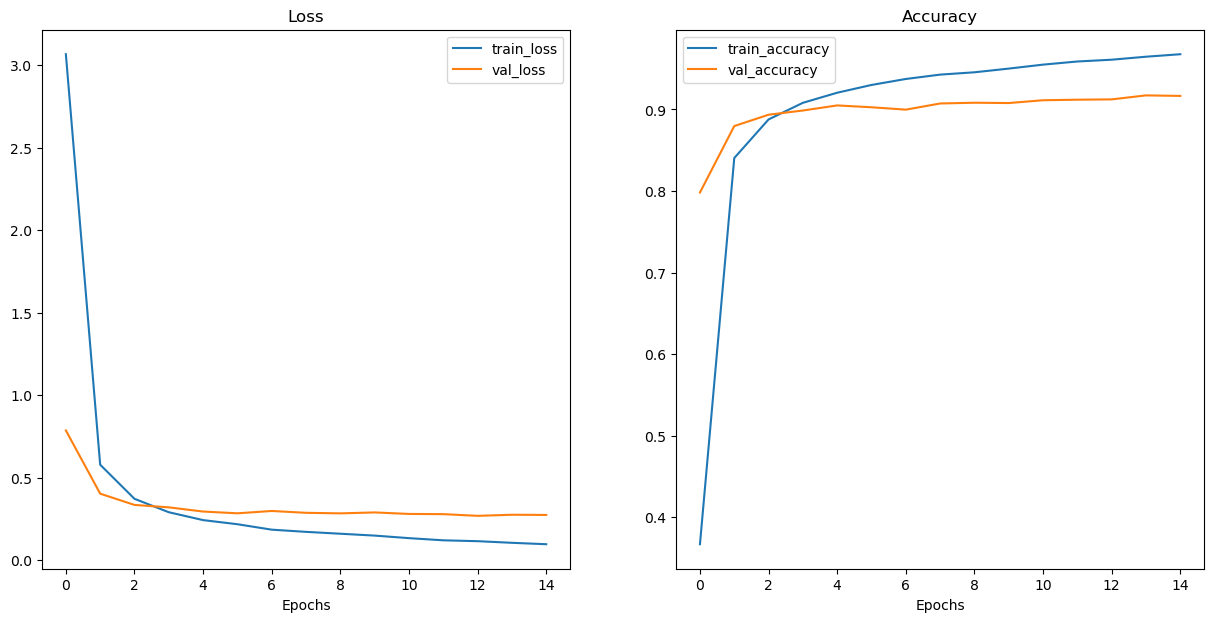

In [ ]:
plot_loss_curves(results)

In [ ]:
torch.save(model_3.state_dict(), 'model_3_weights.pth')

In [ ]:
#alexnet
import torch
import torch.nn as nn
import torchvision.models as models

alexnet = models.alexnet(weights='DEFAULT')

alexnet.features[0] = nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2), bias=False)

alexnet.classifier = nn.Sequential(*list(alexnet.classifier.children())[:-1])
class CustomAlexNet(nn.Module):
    def __init__(self, base_model, num_classes):
        super(CustomAlexNet, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = 238

device = torch.device("cuda")
model_4 = CustomAlexNet(alexnet, num_classes).to(device)
print("Model 4 setup complete")

for param in model_4.parameters():
    param.requires_grad = True

print("Parameter status after unfreezing all layers and applying dropout:")
for name, param in model_4.named_parameters():
    print(f"{name}: Requires grad: {param.requires_grad}")

Model 4 setup complete
Parameter status after unfreezing all layers and applying dropout:
base_model.features.0.weight: Requires grad: True
base_model.features.3.weight: Requires grad: True
base_model.features.3.bias: Requires grad: True
base_model.features.6.weight: Requires grad: True
base_model.features.6.bias: Requires grad: True
base_model.features.8.weight: Requires grad: True
base_model.features.8.bias: Requires grad: True
base_model.features.10.weight: Requires grad: True
base_model.features.10.bias: Requires grad: True
base_model.classifier.1.weight: Requires grad: True
base_model.classifier.1.bias: Requires grad: True
base_model.classifier.4.weight: Requires grad: True
base_model.classifier.4.bias: Requires grad: True
fc.weight: Requires grad: True
fc.bias: Requires grad: True


In [ ]:
try:
    import torchinfo
except ImportError:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

input_size = [1, 1, 227, 227]

summary(model_4, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
CustomAlexNet                            [1, 238]                  --
├─AlexNet: 1-1                           [1, 4096]                 --
│    └─Sequential: 2-1                   [1, 256, 6, 6]            --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           7,744
│    │    └─ReLU: 3-2                    [1, 64, 56, 56]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 27, 27]           --
│    │    └─Conv2d: 3-4                  [1, 192, 27, 27]          307,392
│    │    └─ReLU: 3-5                    [1, 192, 27, 27]          --
│    │    └─MaxPool2d: 3-6               [1, 192, 13, 13]          --
│    │    └─Conv2d: 3-7                  [1, 384, 13, 13]          663,936
│    │    └─ReLU: 3-8                    [1, 384, 13, 13]          --
│    │    └─Conv2d: 3-9                  [1, 256, 13, 13]          884,992
│    │    └─ReLU: 3-10                   [1, 256, 13, 13]          

In [ ]:
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_4.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
epochs = 15
results = train(model_4, train_loader, val_loader, optimizer, criterion, epochs)

Processed 10/472 batches. Current loss: 5.5139
Processed 20/472 batches. Current loss: 5.5011
Processed 30/472 batches. Current loss: 5.4835
Processed 40/472 batches. Current loss: 5.4746
Processed 50/472 batches. Current loss: 5.4608
Processed 60/472 batches. Current loss: 5.4348
Processed 70/472 batches. Current loss: 5.3939
Processed 80/472 batches. Current loss: 5.3370
Processed 90/472 batches. Current loss: 5.2717
Processed 100/472 batches. Current loss: 5.1936
Processed 110/472 batches. Current loss: 5.0986
Processed 120/472 batches. Current loss: 4.9944
Processed 130/472 batches. Current loss: 4.8952
Processed 140/472 batches. Current loss: 4.7933
Processed 150/472 batches. Current loss: 4.6901
Processed 160/472 batches. Current loss: 4.5849
Processed 170/472 batches. Current loss: 4.4823
Processed 180/472 batches. Current loss: 4.3929
Processed 190/472 batches. Current loss: 4.2968
Processed 200/472 batches. Current loss: 4.2068
Processed 210/472 batches. Current loss: 4.1175
P

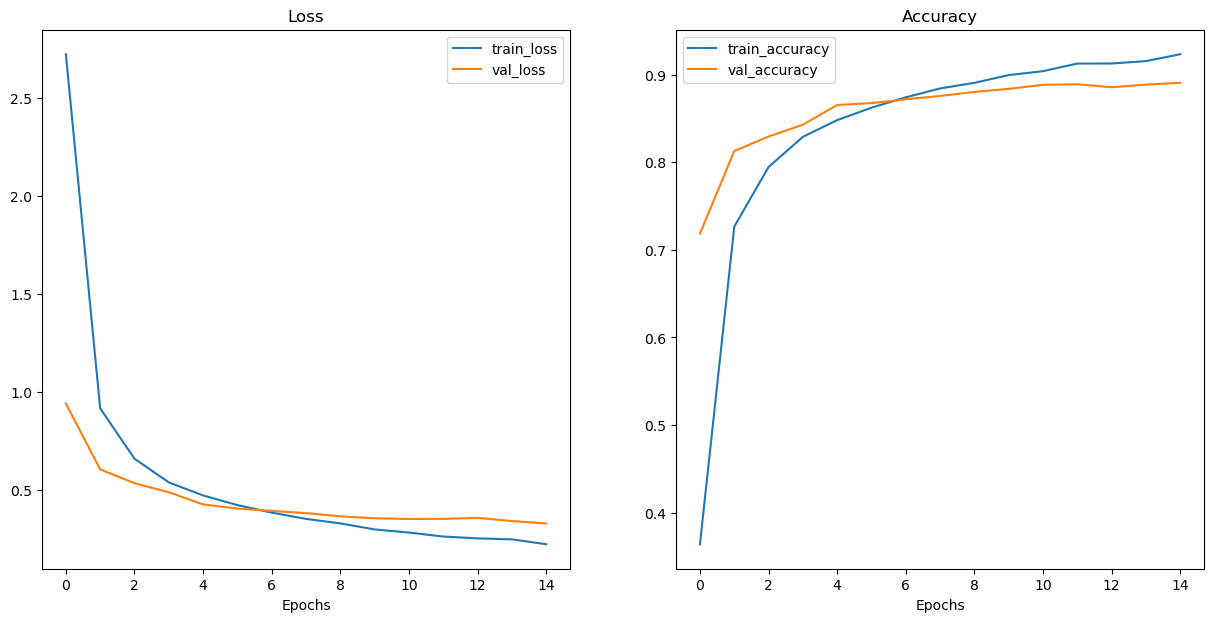

In [ ]:
plot_loss_curves(results)

In [ ]:
torch.save(model_4.state_dict(), 'model_4_weights.pth')